In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

## Data generating process

In [2]:
class DataGeneration():
    def __init__(self, Nd=8, poldeg=2, xmin=0.0, xmax=0.5, error=0.1, seed=None):
        self.rng=np.random.default_rng(seed=seed)
        self.xdata = np.sort(self.rng.uniform(low=xmin, high=xmax, size=(Nd,1)),axis=0)
        self.true_params = self.rng.uniform(low=-5.0, high=5, size=poldeg+1,)
        self.sigma_error=error
        self.ydata = self.measurement()
        
    def true_model(self, params, xdata):
        ytrue = np.polynomial.polynomial.polyval(xdata, params)
        return ytrue

    def measurement(self):
        ydata = self.true_model(self.true_params, self.xdata)
        error = self.rng.normal(0,self.sigma_error,len(self.xdata)).reshape(-1,1)
        return ydata+error

In [12]:
xmin=0.0
xmax=0.5
Nd=8
poldeg=2
seed=42
process = DataGeneration(Nd=Nd, poldeg=poldeg, xmin=xmin, xmax=xmax, seed=seed)

In [13]:
process.true_params

array([-3.71886367, -0.49614062, -1.29201976])

In [14]:
process.xdata

array([[0.04708867],
       [0.21943922],
       [0.34868401],
       [0.38056985],
       [0.38697802],
       [0.39303215],
       [0.42929896],
       [0.48781118]])

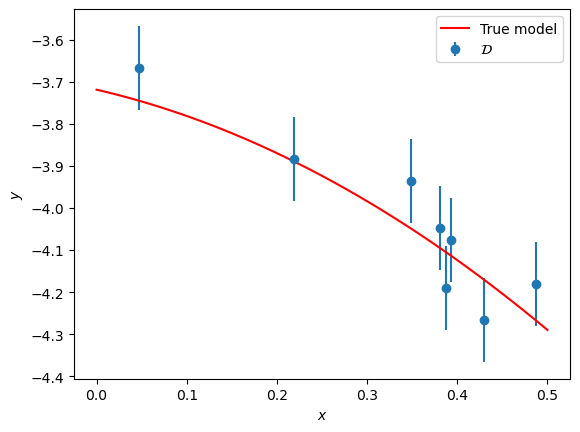

In [15]:
fig,ax = plt.subplots(1,1)
ax.errorbar(process.xdata.flatten(),process.ydata.flatten(),yerr=process.sigma_error,fmt='o',label=r'$\mathcal{D}$')
x_plot = np.linspace(xmin,xmax,100)
y_plot = process.true_model(process.true_params, x_plot)
ax.plot(x_plot, y_plot, 'r-', label='True model')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.legend(loc='best');

## Linear Regression class

In [16]:
class LinearRegression:
    def __init__(self, xdata, ydata, poldeg):
        self.xdata = np.array(xdata).reshape(-1, 1)
        self.ydata = np.array(ydata).reshape(-1, 1)
        self.poldeg = poldeg
        self.Np = poldeg+1
        self.Nd = len(xdata)
        assert self.Nd > self.Np, "Must have more data than parameters. Aborting"
        self.design_matrix = self.create_polynomial_design_matrix(self.xdata)
        self.theta_opt, self.XTXinv = self.solve_normal_equation()
        self.residuals_opt = self.ydata - self.predict(self.theta_opt, self.xdata)
        self.variance_opt = self.estimate_variance_opt()

    def create_polynomial_design_matrix(self, xdata):
        """
        Create a design matrix for a polynomial model, and return it.
        """
        xdata = np.array(xdata).reshape(-1,1)
        design_matrix = np.ones_like(xdata)
        for deg in range(1, self.poldeg+1):
            design_matrix = np.hstack((design_matrix, xdata**deg))
        return design_matrix

    def predict(self, theta, xpred):
        """
        Perform a prediction, y_pred = X_pred \theta.
        """
        Xpred = self.create_polynomial_design_matrix(xpred)
        ypred = np.matmul(Xpred, theta)
        return ypred

    def solve_normal_equation(self):
        """
        Solves the normal equation and updates the parameters theta.
        """
        X = self.design_matrix
        # matrix-matrix and matrix-vector operations
        XTX = np.matmul(X.T, X)
        XTy = np.matmul(X.T, self.ydata)
        # pseudoinverse
        XTXinv = np.linalg.inv(XTX)
        # solution of the normal equation
        theta = np.matmul(XTXinv,XTy)
        return theta, XTXinv

    def estimate_variance_opt(self):
        """
        Unbiased estimator of the variance
        """
        variance_opt = np.matmul(self.residuals_opt.T,self.residuals_opt) / (self.Nd-self.Np)
        return variance_opt[0,0]

    def confidence_interval_estimate_sigma(self,alpha):
        """
        1-alpha confidence interval when sigma must be estimated from data
        """
        tscale = stats.t.ppf(1-alpha/2.,df=self.Nd-self.Np,loc=0,scale=1.)
        s_sq = self.variance_opt
        d_theta = np.sqrt( s_sq * np.diag(self.XTXinv) ) * tscale
        lo = self.theta_opt.flatten() - d_theta.flatten()
        hi = self.theta_opt.flatten() + d_theta.flatten()
        return(lo,hi)

    def confidence_interval_known_sigma(self,alpha, sigma):
        """
        1-alpha confidence interval when sigma is known
        """
        nscale = stats.norm.ppf(1-alpha/2.,loc=0,scale=1.)
        s_sq = sigma**2
        d_theta = np.sqrt( s_sq * np.diag(self.XTXinv) ) * nscale
        lo = self.theta_opt.flatten() - d_theta.flatten()
        hi = self.theta_opt.flatten() + d_theta.flatten()
        return(lo,hi)

### Optimal parameters, estimated variance, confidence interval

In [18]:
poldeg_model = len(process.true_params)-1

In [19]:
LinearModel = LinearRegression(process.xdata, process.ydata, poldeg_model)

In [20]:
LinearModel.theta_opt

array([[-3.6147605 ],
       [-1.06324813],
       [-0.44746295]])

### Resample data

In [26]:
LinearModel_newdata = LinearRegression(process.xdata, process.measurement(), poldeg_model)

In [27]:
LinearModel_newdata.theta_opt

array([[-3.58427494],
       [-1.26295313],
       [-0.28515624]])

## Overfit model

In [28]:
poldeg_overfit = 5
LinearModel_overfit = LinearRegression(process.xdata, process.ydata, poldeg_overfit)
LinearModel_overfit.theta_opt

array([[  -2.32664733],
       [ -40.68007844],
       [ 296.94421956],
       [-841.307314  ],
       [ 887.68656757],
       [-191.0503649 ]])

In [29]:
process.true_params

array([-3.71886367, -0.49614062, -1.29201976])

In [31]:
LinearModel_overfit = LinearRegression(process.xdata, process.measurement(), poldeg_overfit)
LinearModel_overfit.theta_opt

array([[ 6.54095882e+00],
       [-3.37546981e+02],
       [ 3.07799503e+03],
       [-1.20192836e+04],
       [ 2.13549187e+04],
       [-1.42169146e+04]])

## Confidence intervals

In [32]:
LinearModel.theta_opt

array([[-3.6147605 ],
       [-1.06324813],
       [-0.44746295]])

In [33]:
LinearModel.confidence_interval_estimate_sigma(0.05)

(array([-3.919816  , -3.62668179, -5.25411342]),
 array([-3.30970499,  1.50018553,  4.35918751]))

In [34]:
LinearModel.confidence_interval_known_sigma(0.05,process.sigma_error)

(array([-3.88011573, -3.29307365, -4.62857052]),
 array([-3.34940526,  1.16657738,  3.73364461]))

In [35]:
process.true_params

array([-3.71886367, -0.49614062, -1.29201976])

### Test confidence intervals

In [36]:
N_future_data = 10000
N_pars = len(process.true_params)
in_CI = np.zeros((N_future_data,N_pars))
in_CI_known_sigma = np.zeros((N_future_data,N_pars))
alpha = 0.05
for idata in range(N_future_data):
    LinearModel_i = LinearRegression(process.xdata, process.measurement(), N_pars-1)
    lo,hi = LinearModel_i.confidence_interval_estimate_sigma(alpha)
    in_CI[idata,:] = np.logical_and(process.true_params > lo, process.true_params < hi)
    lo,hi = LinearModel_i.confidence_interval_known_sigma(alpha, process.sigma_error)
    in_CI_known_sigma[idata,:] = np.logical_and(process.true_params > lo, process.true_params < hi)

In [37]:
np.sum(in_CI,axis=0) / N_future_data

array([0.9482, 0.9479, 0.948 ])

In [38]:
np.sum(in_CI_known_sigma,axis=0) / N_future_data

array([0.9477, 0.9477, 0.9475])

### Overfit model: Confidence interval

In [39]:
poldeg_overfit = 5
LinearModel_overfit = LinearRegression(process.xdata, process.ydata, poldeg_overfit)
LinearModel_overfit.theta_opt

array([[  -2.32664733],
       [ -40.68007844],
       [ 296.94421956],
       [-841.307314  ],
       [ 887.68656757],
       [-191.0503649 ]])

In [41]:
lo,hi = LinearModel_overfit.confidence_interval_estimate_sigma(alpha)
for ipar, par in enumerate(LinearModel_overfit.theta_opt.flatten()):
    print(f'par {ipar}: {par:7.2f} {100*(1-alpha):.0f}% CI = [{lo[ipar]:.2f}, {hi[ipar]:.2f}]')

par 0:   -2.33 95% CI = [-28.77, 24.12]
par 1:  -40.68 95% CI = [-913.15, 831.79]
par 2:  296.94 95% CI = [-7630.65, 8224.54]
par 3: -841.31 95% CI = [-31386.76, 29704.15]
par 4:  887.69 95% CI = [-52480.57, 54255.95]
par 5: -191.05 95% CI = [-35078.66, 34696.56]
